## Planar data classification with one hidden layer

In [1]:
# Below are some utility functions used in the rest of the notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y)
    

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

### Dataset

In [3]:
X, Y = load_planar_dataset()

In [4]:
X.shape,Y.shape

((2, 400), (1, 400))

In [5]:
X.shape[1]# No. of training samples

400

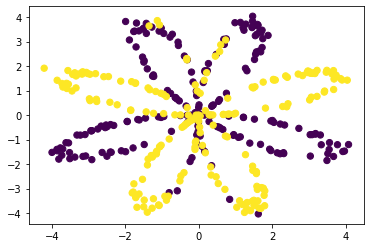

In [6]:
plt.scatter(X[0,:],X[1,:],s=40,c=Y)
plt.show()

### Simple logisitic regression

In [7]:
model = sklearn.linear_model.LogisticRegressionCV()
model.fit(X.T,Y.T)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegressionCV()

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


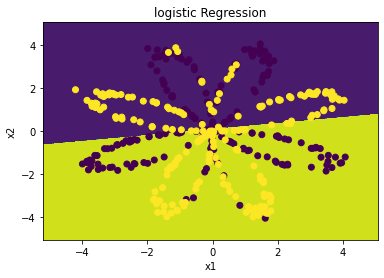

In [8]:
plot_decision_boundary(lambda x: model.predict(x),X,Y)
plt.title("logistic Regression")

preds = model.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,preds) + np.dot(1-Y,1-preds))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

### Neural Network model

In [9]:
def layer_sizes(X,Y):
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

In [10]:
def initialize_parameters(n_x,n_h,n_y):
    np.random.seed(2)
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2}
    
    return parameters

In [11]:
#Forward Propogation
def forward_propogation(X,parameters):
    W1 = parameters["W1"]
    b1=parameters["b1"]
    W2 = parameters["W2"]
    b2=parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    forward_params = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    return A2, forward_params

In [12]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1] # number of example
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), 1 - Y)
    cost = (-1./ m)* np.sum(logprobs)
    #print(cost.shape)
    cost = np.squeeze(cost)
    #cost = cost.astype(float)
    return cost

In [13]:
def backward_propagation(parameters,forward_params,X,Y):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = forward_params["A1"]
    A2 = forward_params["A2"]
    
    m = X.shape[1]
    
    #Calculating dw1,db1,dw2,db2 values
    dZ2 = A2-Y
    dW2 = (1./m) * (np.dot(dZ2,A1.T))
    db2 = (1./m) * (np.sum(dZ2,axis=1,keepdims=True))
    
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))
    dW1 = (1./m) * (np.dot(dZ1,X.T))
    db1 = (1./m) * (np.sum(dZ1,axis=1,keepdims=True))
    
    grads = {"dW1": dW1,"db1": db1,"dW2": dW2,"db2": db2}
    
    return grads

### General Gradient Descent

In [14]:
def update_parameters(parameters, grads, learning_rate = 1.2):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    
    updated_parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return updated_parameters

### Building neural network model

In [15]:
def nn_model(X, Y, n_h, num_iterations = 10000,print_cost=True):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, forward_params".
        A2, forward_params = forward_propogation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, forward_params, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, forward_params, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)

        if print_cost==True and i%1000==0:
            #print("grads")
            #print(grads)
            #print("final parameters")
            #print(parameters)
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [16]:
nn_parameters = nn_model(X, Y, 4, num_iterations=5000)
print("W1 = " + str(nn_parameters["W1"]))
print("b1 = " + str(nn_parameters["b1"]))
print("W2 = " + str(nn_parameters["W2"]))
print("b2 = " + str(nn_parameters["b2"]))

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
W1 = [[ 0.06982332 -8.63128138]
 [-8.25746883  2.69563158]
 [-8.13620915 -9.61151992]
 [ 7.59365484 -8.36389756]]
b1 = [[-0.05906382]
 [-0.38025831]
 [-0.0632713 ]
 [ 0.06172118]]
W2 = [[-9.61324638  3.12475944  5.16892775  8.831244  ]]
b2 = [[-0.05128642]]


In [17]:
def predict(parameters, X):

    A2, forward_params = forward_propogation(X, parameters)
    predictions = (A2 > 0.5)
 
    
    return predictions

In [20]:
predictions = predict(nn_parameters , X)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.505


In [21]:
predictions.shape

(1, 400)

In [22]:
predictions[:,0:5]

array([[False,  True,  True,  True, False]])

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

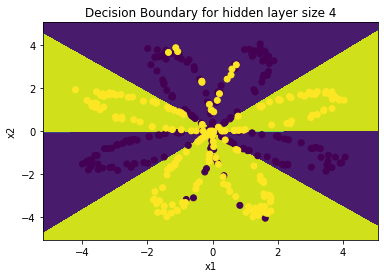

In [24]:
# Build a model with a n_h-dimensional hidden layer
#parameters = nn_model(X, Y, n_h = 4, num_iterations = 5000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(nn_parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [25]:
print("Accuracy")
val = np.float(np.dot(Y,predictions.T)+ np.dot(1-Y,1-predictions.T))/float(Y.size)*100
print(val)

Accuracy
90.5


### Tuning Hyperparameters

Cost after iteration 0: 0.693148
Cost after iteration 1000: 0.636621
Cost after iteration 2000: 0.634757
Cost after iteration 3000: 0.633814
Cost after iteration 4000: 0.633205
Cost after iteration 0: 0.693116
Cost after iteration 1000: 0.582325
Cost after iteration 2000: 0.578948
Cost after iteration 3000: 0.577291
Cost after iteration 4000: 0.576190
Cost after iteration 0: 0.693114
Cost after iteration 1000: 0.285502
Cost after iteration 2000: 0.273063
Cost after iteration 3000: 0.266367
Cost after iteration 4000: 0.262067
Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 0: 0.693252
Cost after iteration 1000: 0.283771
Cost after iteration 2000: 0.270689
Cost after iteration 3000: 0.263510
Cost after iteration 4000: 0.258455
Cost after iteration 0: 0.693166
Cost after iteration 1000: 0.276804
Cost after iteration 2000: 0.194106
Cost after

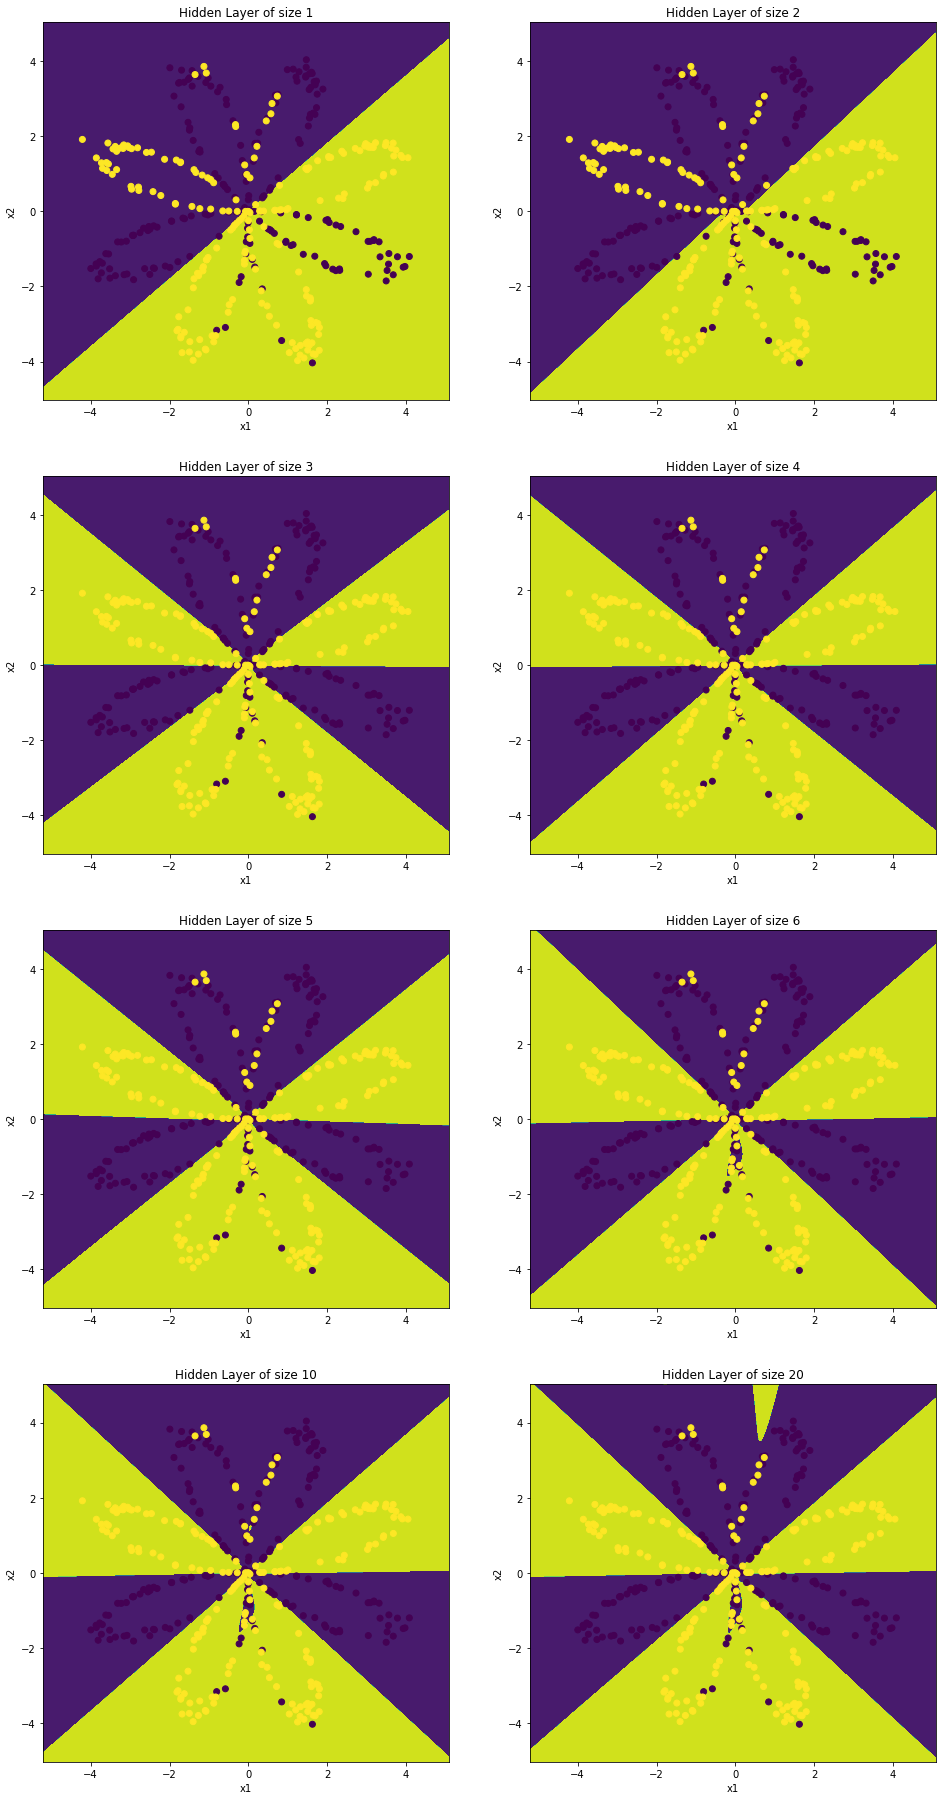

In [28]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 6,10,20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(4, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))